#### Classify model from Yu, et al
Implementation of the classification model from the Yu, et al [paper](https://drive.google.com/file/d/1nYl4w41CAcj8XwTEdVwcD5lVheUFIHVy/view?usp=sharing)

Refinement on first run. Data was resized to 224x224 and median filtered 7x7. Classes were augmented to max class count using random flips and rotations.

Still tries to follow the paper as closely as possible, but some changes from the first run:
- Added last fully connected layer (FC3) that was accidentally omitted in the first run.
- Added second dropout layer that was accidentally omitted in first run (dropout applied to FC1 and FC2 instead of just FC2).
- Adjusted L2 regularization to 0.001 instead of 0.000001 for both FC1 and FC2 (overfitting observed in first run).
- Saved both model and predictions.

In [1]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers

import os
import numpy as np
import pandas as pd
import pickle5 as pickle

import helpers as helper
import seaborn as sns
from sklearn.metrics import confusion_matrix

import time

In [2]:
# specify variables for model
path = '../../data/resized224'
filename = 'WM-clean-id224filter7'
option = '-clsaug' # -clsaug, -detund
map_column = 'filterMap7'
label_column = 'classifyLabels'
filetype = 'zip' # zip, pkl

model_id = 'yuclassify'
result_path = '../../results'
model_path = '../../saved_models'
note = '-firstrun3' # -optional

In [3]:
# load train, dev, and test sets

start = time.time()

if filetype == 'pkl':
    # open pkl files
    with open(f'{path}/{filename}-train{option}.pkl', "rb") as fh:
        train = pickle.load(fh)
    with open(f'{path}/{filename}-dev.pkl', "rb") as fh:
        dev = pickle.load(fh)
    with open(f'{path}/{filename}-test.pkl', "rb") as fh:
        test = pickle.load(fh)

elif filetype == 'zip':
    train = helper.load(f'{path}/{filename}-train{option}.zip')
    dev = helper.load(f'{path}/{filename}-dev.zip')
    test = helper.load(f'{path}/{filename}-test.zip')

# remove none type from dev and test sets
dev = dev[dev.failureType != 'none']
test = test[test.failureType != 'none']

print("Wall time: {} seconds".format(time.time() - start))
print(f"Train: {len(train)}")
print(f"Dev: {len(dev)}")
print(f"Test: {len(test)}")

Wall time: 111.5657000541687 seconds
Train: 54208
Dev: 3828
Test: 3828


#### Quick EDA

In [4]:
# baseline accuracy of test set
nones = len(test[test.failureType == 'Edge-Ring'])
total = len(test)
print(f"Baseline accuracy: {nones/total*100:.2f}%")

Baseline accuracy: 37.93%


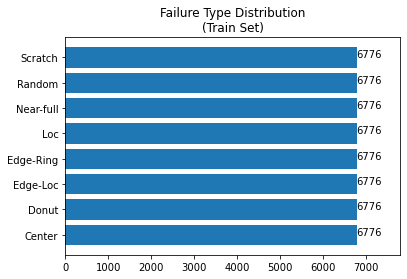

In [5]:
# train failure type distribution
helper.defect_distribution(train, note='Train Set')

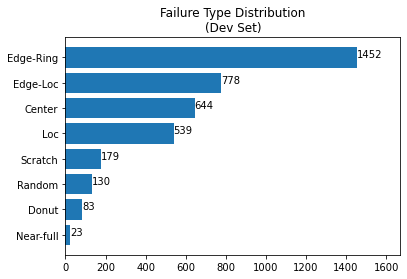

In [6]:
# dev failure type distribution
helper.defect_distribution(dev, note='Dev Set')

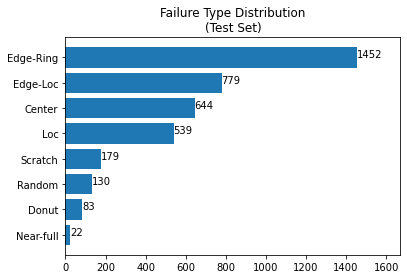

In [7]:
# test failure type distribution
helper.defect_distribution(test, note='Test Set')

#### Data set-up

In [8]:
# prepare inputs
start = time.time()

x_train = np.stack(train[map_column])
x_val = np.stack(dev[map_column])
x_test = np.stack(test[map_column])

print("Wall time: {} seconds".format(time.time() - start))

# sanity check
# expected: (#rows, xdim, ydim)
x_train.shape

Wall time: 51.32604694366455 seconds


(54208, 224, 224)

In [9]:
# expand tensor and create dummy dimension at axis 3
# images in greyscale, so no channel dimension
start = time.time()

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_val = tf.expand_dims(x_val, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

print("Wall time: {} seconds".format(time.time() - start))

# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_train.shape

Wall time: 0.07104706764221191 seconds


TensorShape([54208, 224, 224, 1])

In [10]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
y_train = np.asarray(train[label_column]).astype('int64')
y_val = np.asarray(dev[label_column]).astype('int64')
y_test = np.asarray(test[label_column]).astype('int64')

# subtract 1 from labels to agree with model
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

# sanity check
print(type(y_train[0]))
print(min(y_train), min(y_val), min(y_test))
print(max(y_train), max(y_val), max(y_test))

<class 'numpy.int64'>
0 0 0
7 7 7


#### Model

In [11]:
# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(8, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       7

In [12]:
# set model optimizer and metrics
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [13]:
# run model
history = model.fit(x_train, y_train, batch_size=128, epochs=25, validation_data=(x_val, y_val))

Epoch 1/25
424/424 [==============================] - 2233s 5s/step - loss: 1.7913 - accuracy: 0.5877 - val_loss: 1.1888 - val_accuracy: 0.8030
Epoch 2/25
424/424 [==============================] - 2189s 5s/step - loss: 1.2387 - accuracy: 0.8003 - val_loss: 1.0812 - val_accuracy: 0.8459
Epoch 3/25
424/424 [==============================] - 2231s 5s/step - loss: 1.1121 - accuracy: 0.8294 - val_loss: 0.9498 - val_accuracy: 0.8741
Epoch 4/25
424/424 [==============================] - 2184s 5s/step - loss: 1.0684 - accuracy: 0.8436 - val_loss: 1.0186 - val_accuracy: 0.8550
Epoch 5/25
424/424 [==============================] - 2162s 5s/step - loss: 1.0580 - accuracy: 0.8593 - val_loss: 0.9955 - val_accuracy: 0.8804
Epoch 6/25
424/424 [==============================] - 2152s 5s/step - loss: 1.0464 - accuracy: 0.8710 - val_loss: 0.9749 - val_accuracy: 0.8843
Epoch 7/25
424/424 [==============================] - 2155s 5s/step - loss: 1.0520 - accuracy: 0.8749 - val_loss: 0.9808 - val_accuracy:

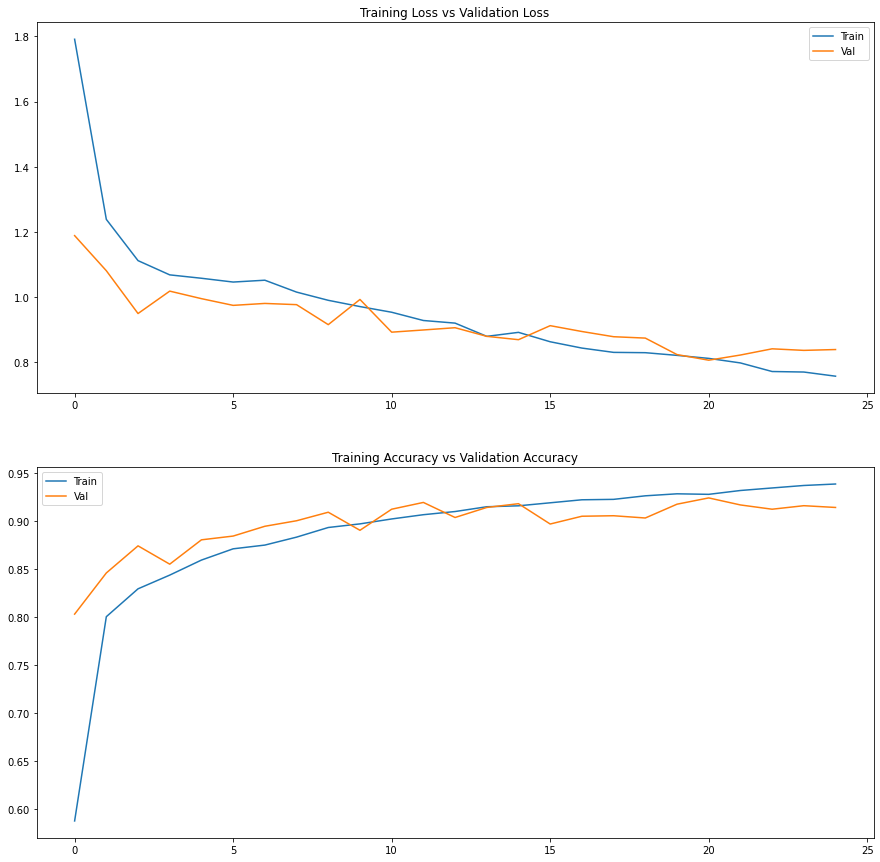

In [14]:
# visualize accuracy and loss history
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [15]:
# compute model results on test set
start = time.time()
results = model.evaluate(x_test, y_test)
print("Wall time: {} seconds".format(time.time() - start))
print()
print(results)

120/120 [==============================] - 47s 391ms/step - loss: 0.8297 - accuracy: 0.9099
Wall time: 47.294676065444946 seconds

[0.8296521306037903, 0.9098746180534363]


In [16]:
# generate predictions for model analysis
start = time.time()
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 42.673425912857056 seconds


In [17]:
# save results, history, and predictions
with open(f'{result_path}/{model_id}-{filename}{option}{note}.pkl', "wb") as f:
    pickle.dump(y_pred, f)

In [18]:
# save model
model.save(f'{model_path}/{model_id}-{filename}{option}{note}')

INFO:tensorflow:Assets written to: ../../saved_models/yuclassify-WM-clean-id224filter7-clsaug-firstrun3/assets


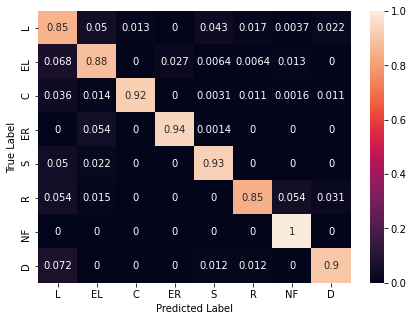

In [19]:
# plot confusion matrix
helper.plot_confusion_matrix(y_test, y_pred, normalize=True)

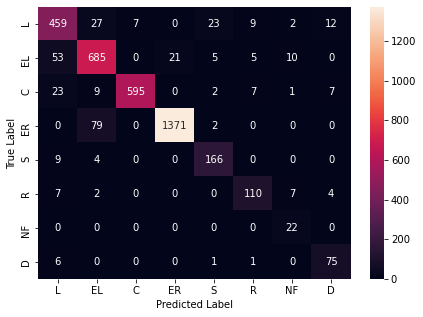

In [20]:
# plot confusion matrix counts
helper.plot_confusion_matrix(y_test, y_pred, normalize=False)